### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Aug  4 06:56:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 116.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download dataset from Roboflow Universe

In [4]:
from google.colab import userdata
ROBOFLOW_API = userdata.get('ROBOFLOW_API')

In [5]:


!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=ROBOFLOW_API)
project = rf.workspace("potholes-r7qcn").project("pothole-jujbl")
version = project.version(1)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pothole-1 in yolov12:: 100%|██████████| 5554/5554 [00:00<00:00, 6915.90it/s]


In [6]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [7]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [8]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Pothole']

roboflow:
  workspace: potholes-r7qcn
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [9]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=30)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.173 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Pothole-1/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=Tru

100%|██████████| 755k/755k [00:00<00:00, 54.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 147MB/s]


AMP: checks passed ✅


train: Scanning /content/Pothole-1/train/labels... 1939 images, 10 backgrounds, 0 corrupt: 100%|██████████| 1939/1939 [00:00<00:00, 2454.09it/s]


train: New cache created: /content/Pothole-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Pothole-1/valid/labels... 555 images, 4 backgrounds, 0 corrupt: 100%|██████████| 555/555 [00:00<00:00, 1220.55it/s]

val: New cache created: /content/Pothole-1/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       6.8G      3.503      3.814       3.98          8        640: 100%|██████████| 122/122 [01:11<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]

                   all        555       1449    0.00222      0.255    0.00206   0.000653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.72G      2.996      3.439      3.271          9        640: 100%|██████████| 122/122 [01:05<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449     0.0625     0.0787     0.0211    0.00656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      6.92G      2.791      3.232      2.961          8        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.33it/s]


                   all        555       1449     0.0635      0.103     0.0293    0.00795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      6.72G       2.64       3.11      2.782         11        640: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.28it/s]


                   all        555       1449      0.113      0.121     0.0482     0.0147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.73G      2.508      2.961      2.657          6        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.34it/s]


                   all        555       1449      0.147      0.102     0.0671     0.0202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.85G      2.392      2.849      2.574         22        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


                   all        555       1449      0.217      0.184      0.117     0.0388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       6.9G      2.318      2.734       2.49          7        640: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


                   all        555       1449      0.242      0.237      0.147     0.0516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.69G      2.243      2.646      2.411         12        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


                   all        555       1449      0.193      0.221      0.121     0.0427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.92G      2.145      2.554       2.33         11        640: 100%|██████████| 122/122 [01:05<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.34it/s]


                   all        555       1449      0.318      0.251      0.198     0.0782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.85G      2.111      2.459      2.264         12        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.37it/s]


                   all        555       1449      0.351      0.293      0.267      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.89G      2.057      2.393      2.206         13        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


                   all        555       1449      0.348       0.32      0.269       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.86G      2.045       2.38      2.182         12        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.299      0.289      0.212     0.0855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.92G      1.997      2.293      2.132          8        640: 100%|██████████| 122/122 [01:05<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.36it/s]


                   all        555       1449      0.433      0.331      0.322      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.86G      1.986      2.259      2.111         11        640: 100%|██████████| 122/122 [01:05<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.34it/s]


                   all        555       1449        0.4      0.335      0.318      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.73G      1.977      2.237      2.085          8        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.40it/s]


                   all        555       1449      0.387      0.358      0.314      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.87G      1.937      2.218      2.056         15        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.57it/s]


                   all        555       1449      0.467      0.371      0.371      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.89G      1.911      2.164      2.029         30        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.42it/s]


                   all        555       1449      0.449      0.364      0.337       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.69G      1.896      2.164      2.034         16        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.35it/s]


                   all        555       1449      0.488       0.36      0.385      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.74G      1.868      2.099      1.986         14        640: 100%|██████████| 122/122 [01:05<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.29it/s]

                   all        555       1449      0.472      0.411      0.397      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.69G      1.855      2.078      1.972         17        640: 100%|██████████| 122/122 [01:04<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.57it/s]


                   all        555       1449      0.424      0.415      0.393      0.189
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.87G      1.843      2.094      1.997          5        640: 100%|██████████| 122/122 [01:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.58it/s]


                   all        555       1449      0.521      0.382      0.403      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.85G      1.805      2.002      1.965          8        640: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.565      0.422      0.464      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.71G      1.782      1.965      1.955         16        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


                   all        555       1449      0.529      0.433      0.471      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.91G      1.772      1.944      1.924          9        640: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]

                   all        555       1449      0.544      0.432      0.474      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.88G      1.764      1.899      1.921          8        640: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.58it/s]


                   all        555       1449      0.569      0.451      0.499      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.85G      1.746      1.866      1.903          8        640: 100%|██████████| 122/122 [01:04<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.45it/s]


                   all        555       1449      0.583      0.461      0.508      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.73G      1.728      1.854        1.9          9        640: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


                   all        555       1449       0.58      0.461      0.513      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.88G      1.707      1.817       1.87         11        640: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


                   all        555       1449      0.598      0.462      0.519      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.91G      1.695      1.785      1.865          8        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.60it/s]


                   all        555       1449      0.593      0.473      0.533      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.69G      1.688      1.774      1.859          4        640: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


                   all        555       1449      0.597      0.488      0.536      0.278

30 epochs completed in 0.619 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,595 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


                   all        555       1449      0.589      0.496      0.537      0.278
Speed: 0.2ms preprocess, 9.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [10]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch1.jpg
confusion_matrix_normalized.png			   train_batch2440.jpg
confusion_matrix.png				   train_batch2441.jpg
events.out.tfevents.1754290756.2c6609e67b36.949.0  train_batch2442.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


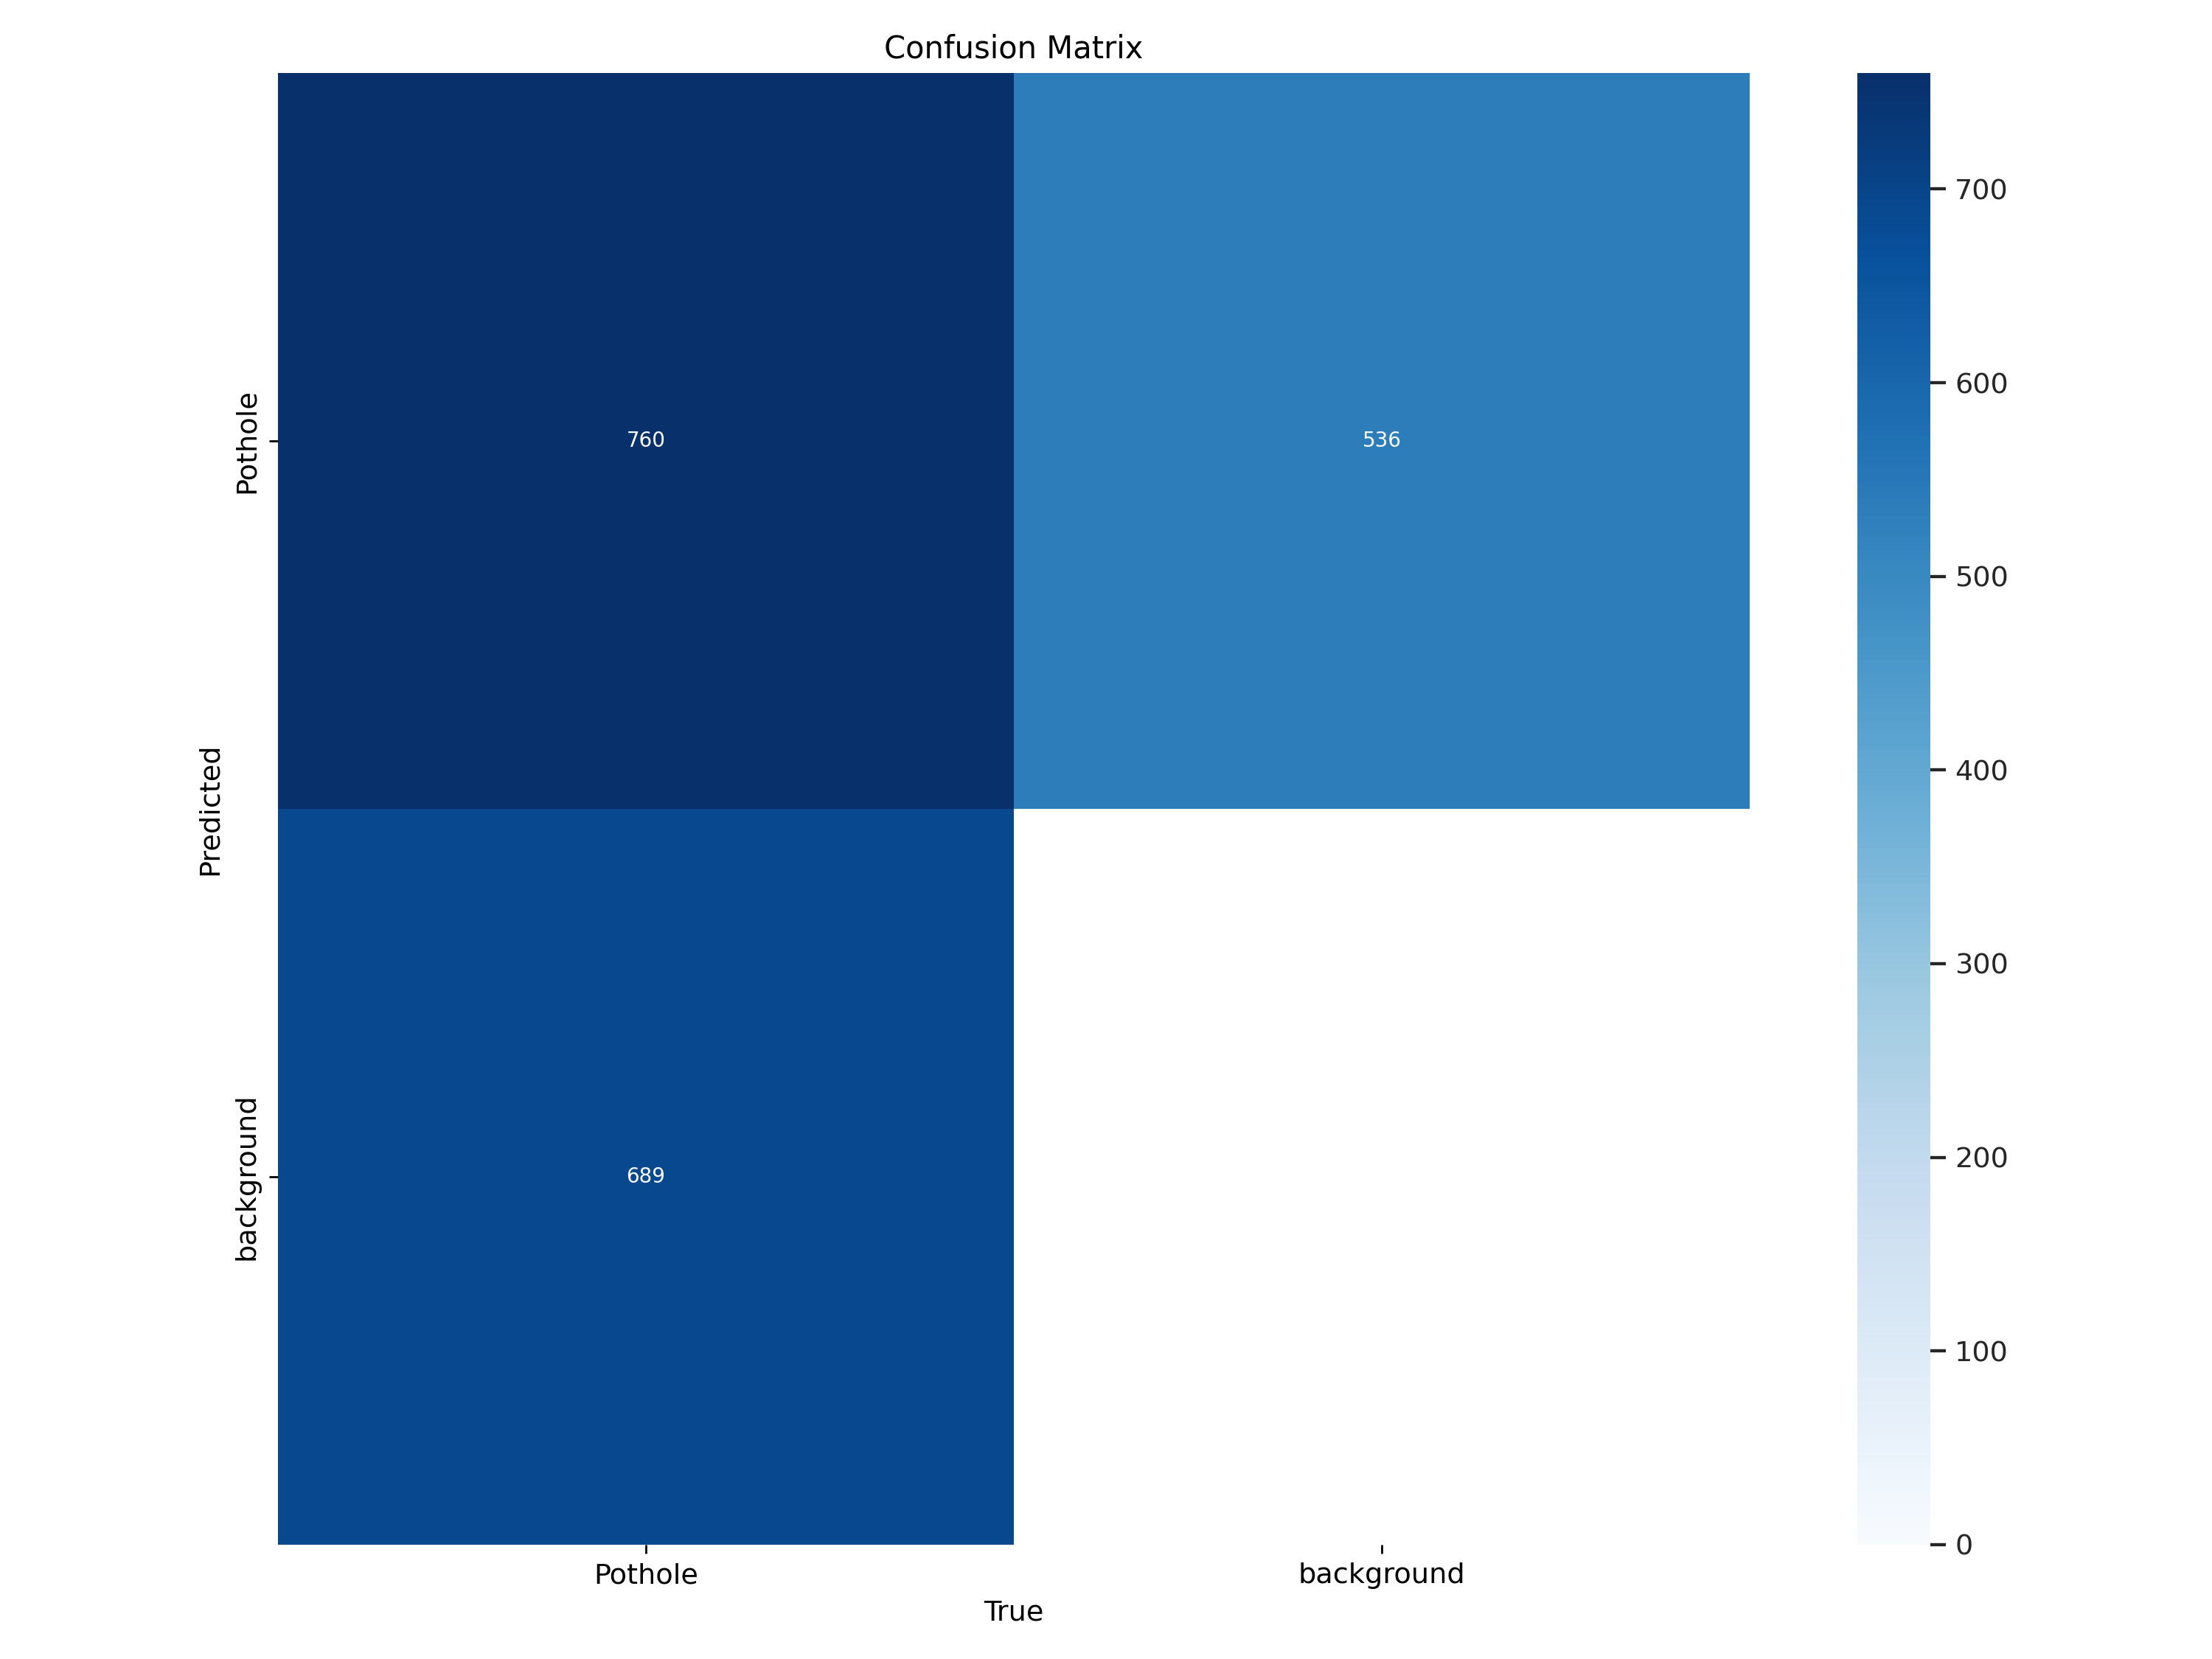

In [11]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

In [12]:

import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch1.jpg
confusion_matrix_normalized.png			   train_batch2440.jpg
confusion_matrix.png				   train_batch2441.jpg
events.out.tfevents.1754290756.2c6609e67b36.949.0  train_batch2442.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


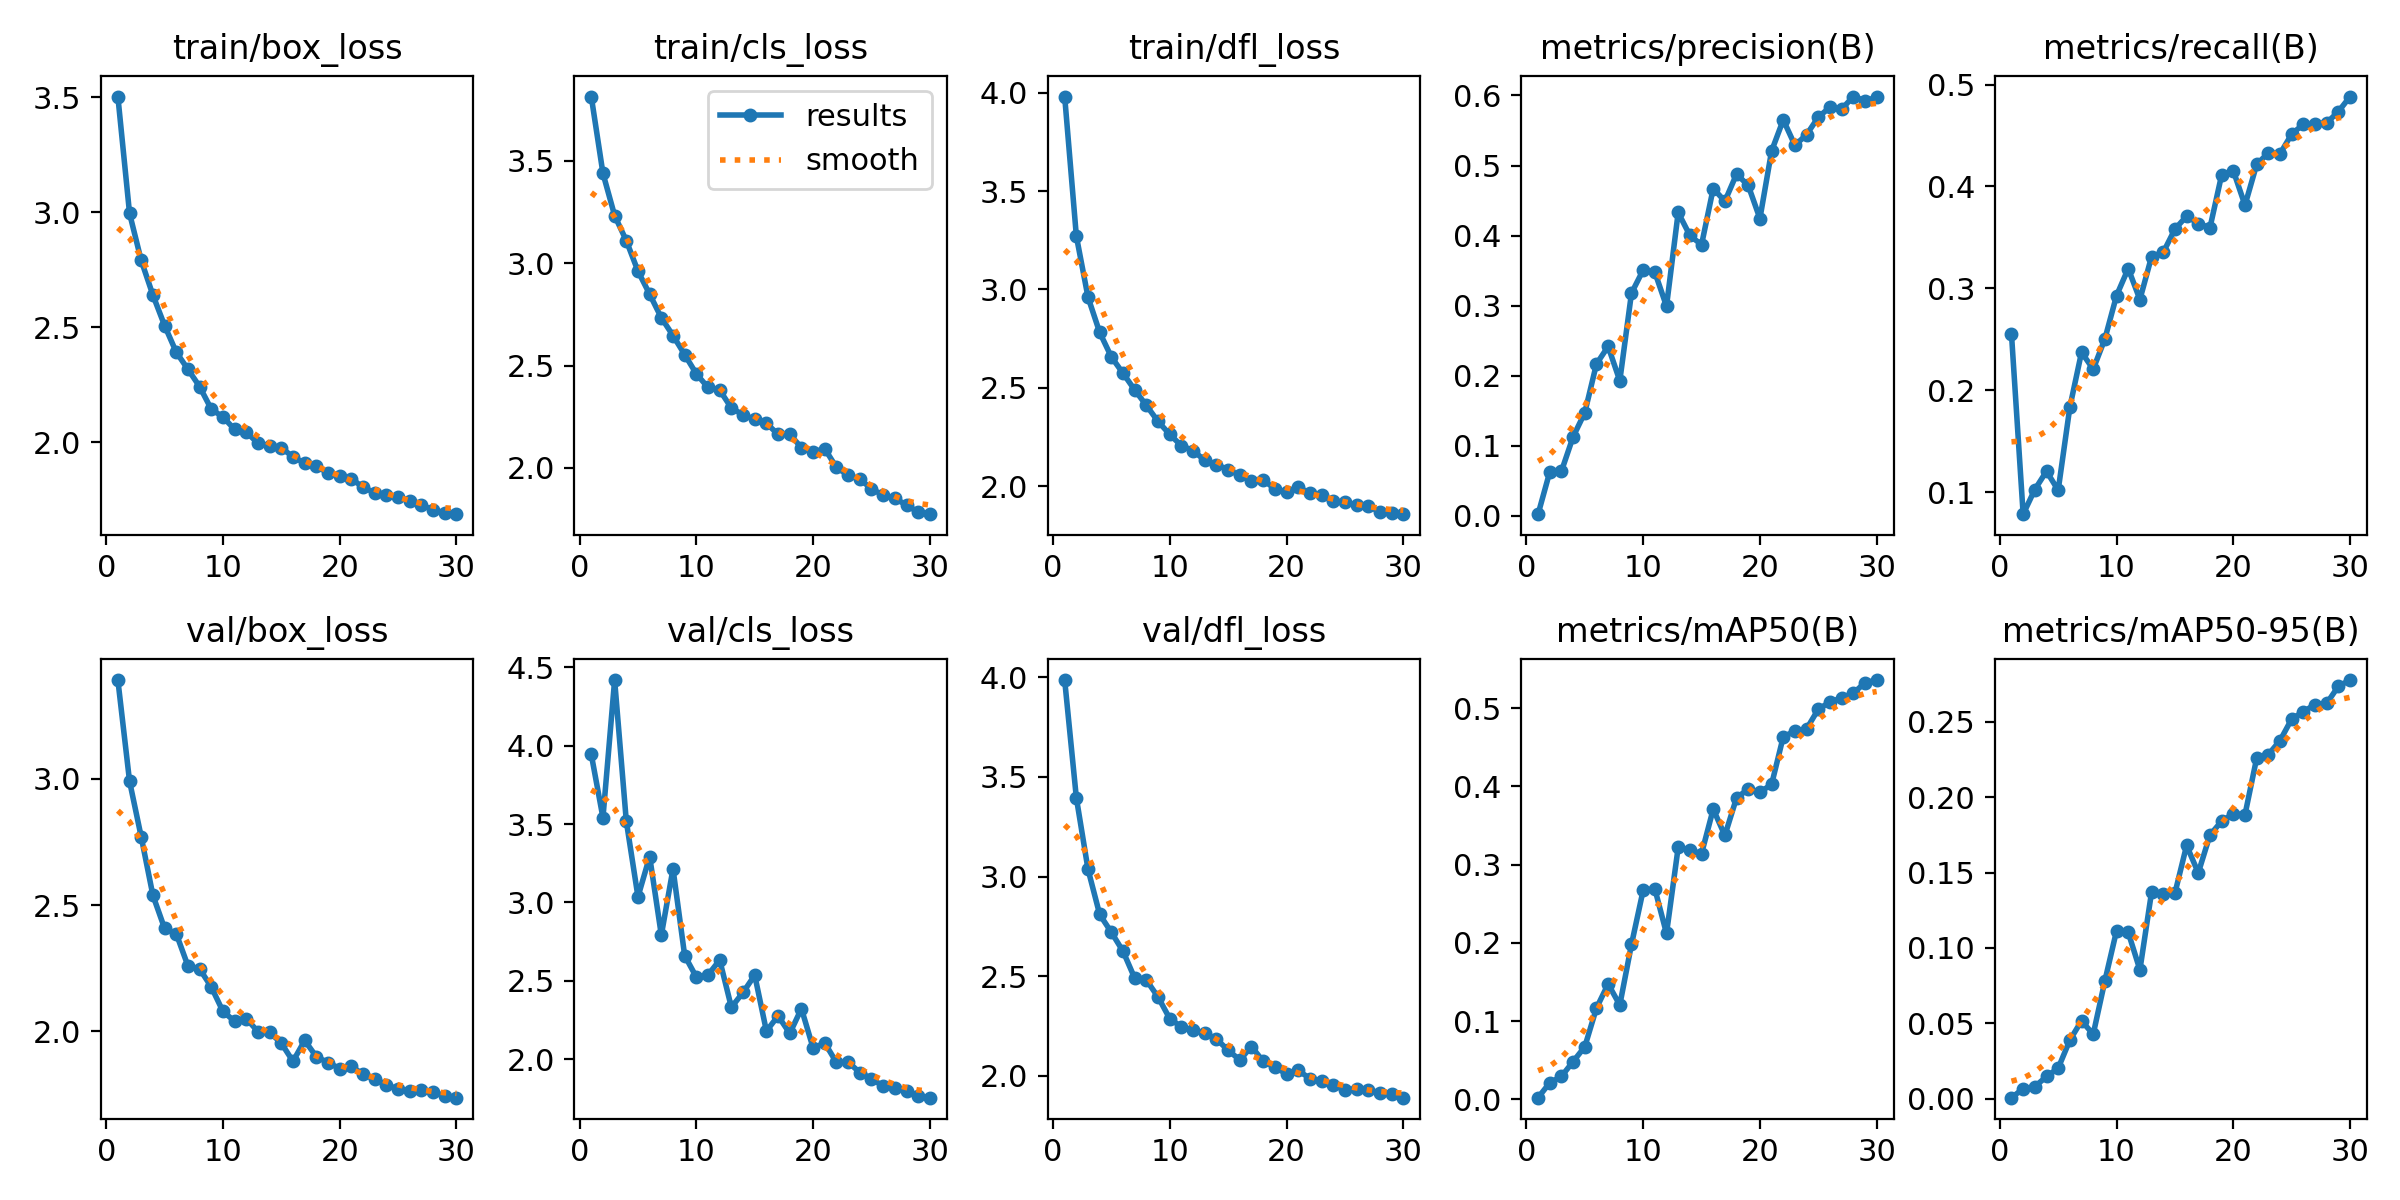

In [13]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [14]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Pothole']

In [15]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [16]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.22770281387492544
mAP 50 0.42575300942716426
mAP 75 0.2257165384920551


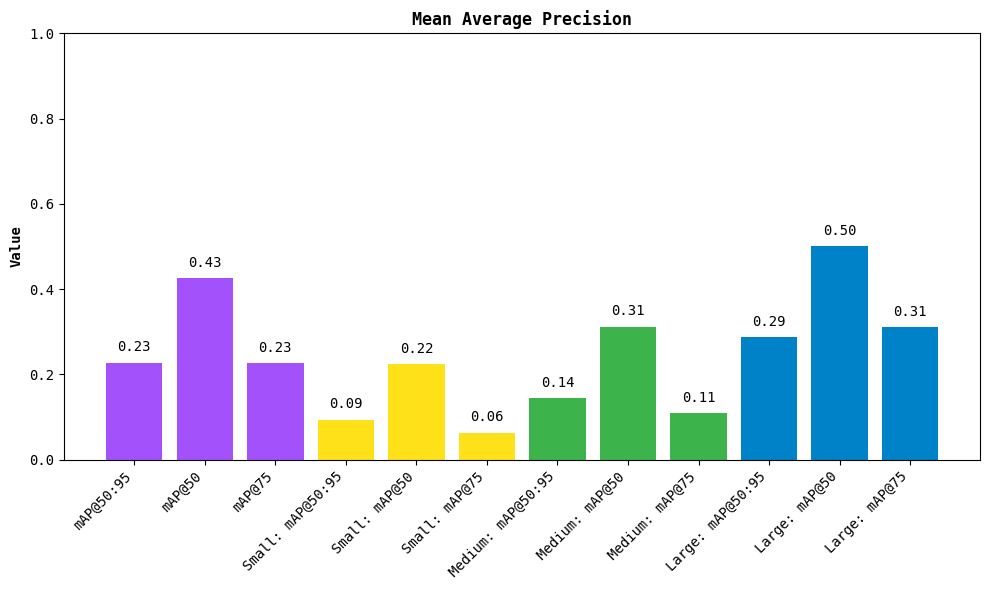

In [17]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [18]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

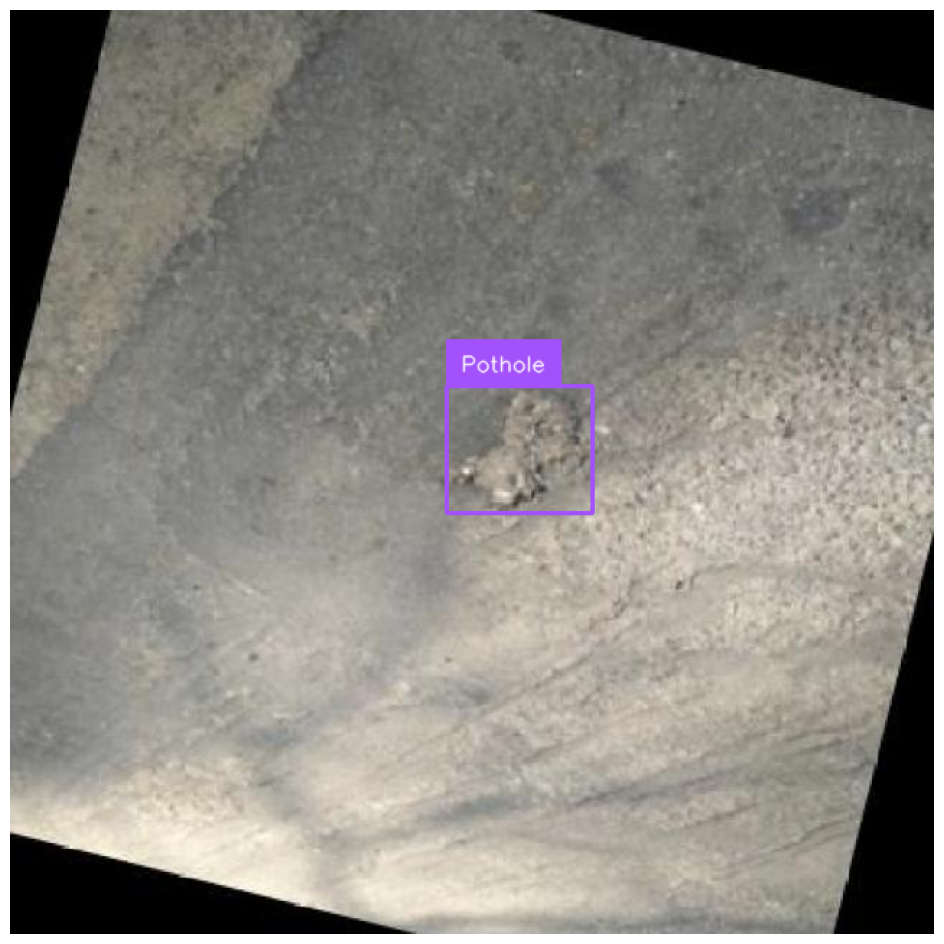

In [19]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [21]:
import supervision as sv
from ultralytics import YOLO
from tqdm import tqdm
import cv2
from google.colab import files

# 1. Set up paths
SOURCE_VIDEO_PATH = "/content/Y.mp4"
TARGET_VIDEO_PATH = "/content/Yannotated.mp4"
MODEL_PATH = "/content/yolov12n.pt"  # adjust if needed

# 2. Load video frames and info
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# 3. Initialize BoxAnnotator
box_annotator = sv.BoxAnnotator(
    thickness=2,
    color_lookup=sv.ColorLookup.CLASS
)

# 4. Load YOLOv8 model
model = YOLO(MODEL_PATH)

# 5. Annotate and write video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames, desc="Processing video"):
        results = model(frame, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results)

        # Filter only class 0 (Potholes)
        pothole_detections = detections[detections.class_id == 0]

        # Annotate bounding boxes
        annotated_frame = box_annotator.annotate(
            scene=frame.copy(),
            detections=pothole_detections
        )

        # (Optional) Add confidence labels manually
        for detection, confidence in zip(pothole_detections.xyxy, pothole_detections.confidence):
            x1, y1, _, _ = map(int, detection)
            label = f"Pothole {confidence:.2f}"
            cv2.putText(
                annotated_frame,
                label,
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 255, 255),
                1,
                cv2.LINE_AA
            )

        sink.write_frame(annotated_frame)

print(f"\n✅ Processing complete! Output saved to {TARGET_VIDEO_PATH}")

# 6. Download video (Colab only)
files.download(TARGET_VIDEO_PATH)

Processing video: 100%|██████████| 692/692 [00:23<00:00, 28.88it/s]


✅ Processing complete! Output saved to /content/Yannotated.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model classes: {0: 'Pothole'}
Processed frame 10/692
Processed frame 20/692
Processed frame 30/692
Processed frame 40/692
Processed frame 50/692
Processed frame 60/692
Processed frame 70/692
Processed frame 80/692
Processed frame 90/692
Processed frame 100/692


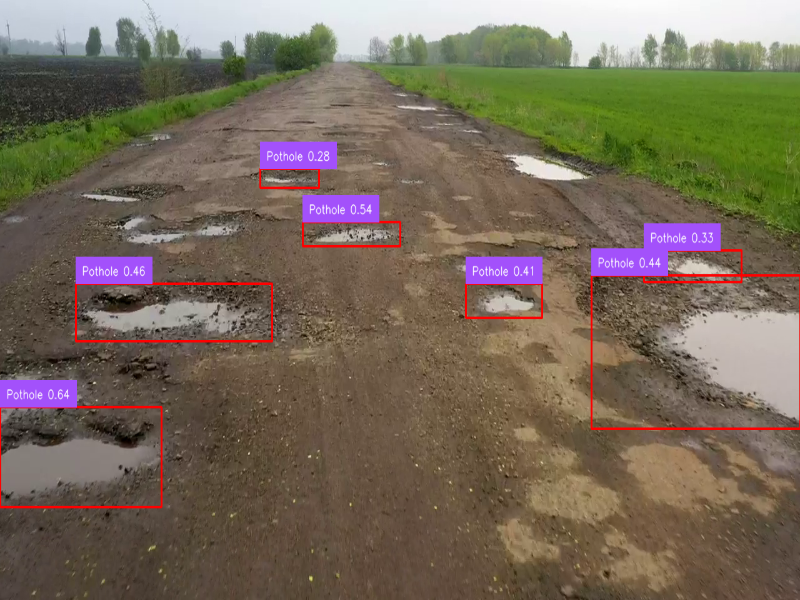

Processed frame 110/692
Processed frame 120/692
Processed frame 130/692
Processed frame 140/692
Processed frame 150/692
Processed frame 160/692
Processed frame 170/692
Processed frame 180/692
Processed frame 190/692
Processed frame 200/692


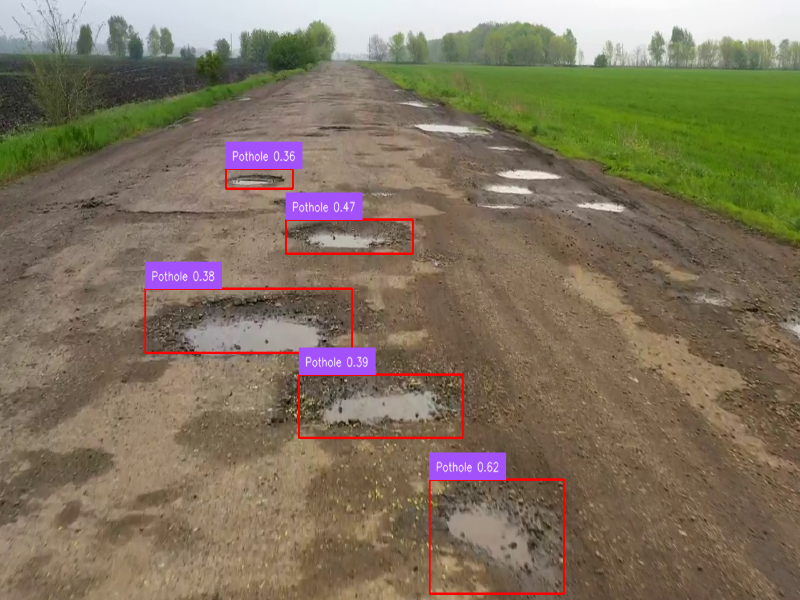

Processed frame 210/692
Processed frame 220/692
Processed frame 230/692
Processed frame 240/692
Processed frame 250/692
Processed frame 260/692
Processed frame 270/692
Processed frame 280/692
Processed frame 290/692
Processed frame 300/692


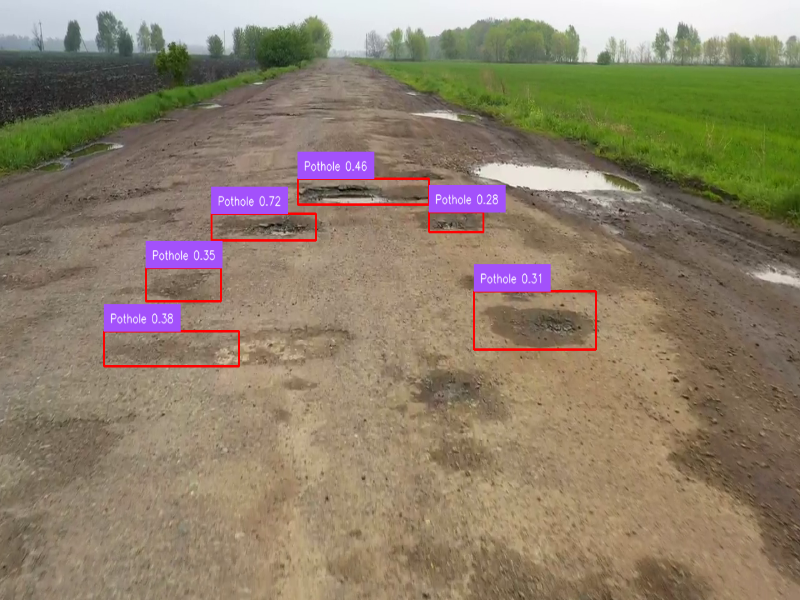

Processed frame 310/692
Processed frame 320/692
Processed frame 330/692
Processed frame 340/692
Processed frame 350/692
Processed frame 360/692
Processed frame 370/692
Processed frame 380/692
Processed frame 390/692
Processed frame 400/692


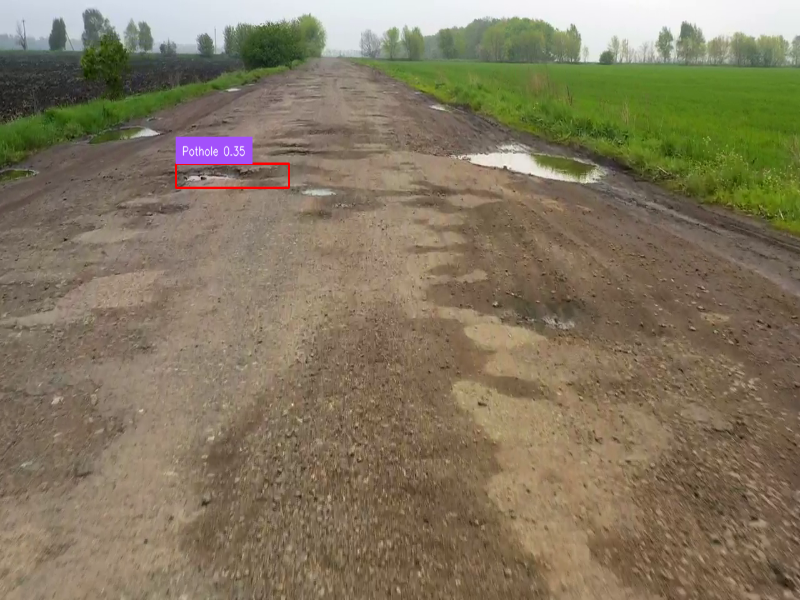

Processed frame 410/692
Processed frame 420/692
Processed frame 430/692
Processed frame 440/692
Processed frame 450/692
Processed frame 460/692
Processed frame 470/692
Processed frame 480/692
Processed frame 490/692
Processed frame 500/692


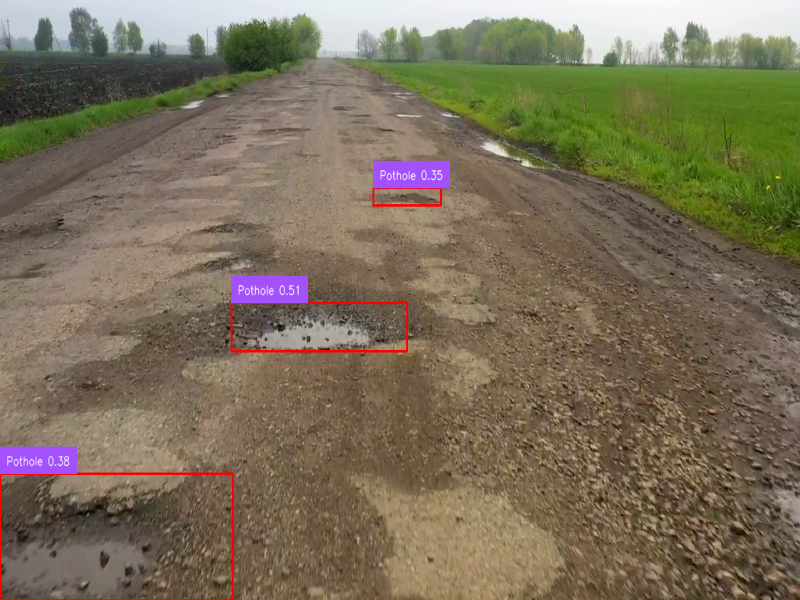

Processed frame 510/692
Processed frame 520/692
Processed frame 530/692
Processed frame 540/692
Processed frame 550/692
Processed frame 560/692
Processed frame 570/692
Processed frame 580/692
Processed frame 590/692
Processed frame 600/692


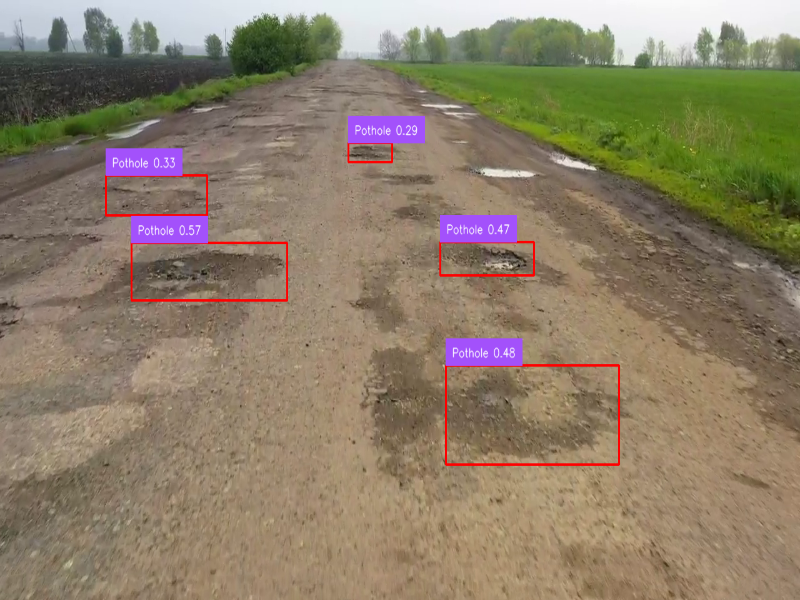

Processed frame 610/692
Processed frame 620/692
Processed frame 630/692
Processed frame 640/692
Processed frame 650/692
Processed frame 660/692
Processed frame 670/692
Processed frame 680/692
Processed frame 690/692
Video processing completed. Releasing resources...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Video processing complete. Saved to: /content/Y_annotated.mp4


In [22]:
import supervision as sv
from ultralytics import YOLO
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files

# 1. Set paths
MODEL_PATH = "/content/runs/detect/train/weights/best.pt"
VIDEO_PATH = "/content/Y.mp4"
OUTPUT_VIDEO_PATH = "/content/Y_annotated.mp4"

# 2. Load model
model = YOLO(MODEL_PATH)
print("Model classes:", model.names)

# 3. Initialize video capture
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError(f"Video not found at {VIDEO_PATH}")

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 4. Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (width, height))

# 5. Initialize annotators
box_annotator = sv.BoxAnnotator(
    color=sv.Color(r=255, g=0, b=0),  # Red boxes
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.WHITE,
    text_scale=0.5,
    text_thickness=1
)

# 6. Process video frame by frame
frame_count = 0
try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Run detection
        results = model(frame, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results).with_nms()

        # Filter potholes (class 0)
        pothole_detections = detections[detections.class_id == 0]

        # Create labels
        labels = [f"Pothole {conf:.2f}" for conf in pothole_detections.confidence]

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = box_annotator.annotate(
            scene=annotated_frame,
            detections=pothole_detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=pothole_detections,
            labels=labels
        )

        # Write frame to output video
        out.write(annotated_frame)

        # Display progress
        frame_count += 1
        if frame_count % 10 == 0:
            print(f"Processed frame {frame_count}/{total_frames}")
            # Display sample frame every 100 frames
            if frame_count % 100 == 0:
                display_frame = cv2.resize(annotated_frame, (800, 600))
                cv2_imshow(display_frame)

finally:
    # 7. Release resources (without cv2.destroyAllWindows)
    cap.release()
    out.release()
    print("Video processing completed. Releasing resources...")

# 8. Download result
files.download(OUTPUT_VIDEO_PATH)
print(f"✅ Video processing complete. Saved to: {OUTPUT_VIDEO_PATH}")